# Generalized Price of Anarchy

James Yu

24 January 2021


## Introduction

The Price of Anarchy is a problem in Computer Science exploring the behaviour of competing users attempting to access a shared set of network resources (Roughgarden, 2005, as cited in Peters, 2016). The simplest version of the problem investigates a hypothetical scenario of two computers attempting to send pieces of data through a network of two routers. Each computer must decide which router to use at the same time as the other computer, forming a strategic game. In addition, one of the routers is defined to be inefficient, only accepting data packets a certain fraction of the time.

In this Jupyter notebook, we will attempt to take this simple problem and expand it to multiple dimensions by using Python. We will first create an expanded model to support an arbitrary number of computers accessing two routers, followed by a model for two computers accessing an arbitrary number of routers. In doing so, we also generalize the model to allow each individual router to have its own probability of processing a packet.

Finally, we will take these two expansions and put them together to form the generalized version of the Price of Anarchy problem, in order to solve the question of how the benefits of a regulated network versus an unregulated network change as the network grows in size.

Much of the code in this notebook was derived from another project involving creating economic Python functions that run within a Discord bot; the source for this bot is available at https://github.com/jbrightuniverse/QuantEcon

## Basic Model

At its core, the basic Price of Anarchy is a 2x2 matrix game. The players are the computers, and the strategies are the routers each website can use.

Each of the routers in the problem is only able to ever process one packet at a time. Thus, the payoffs in the game are  stochastic. A particular payoff represents the *probability* of a packet sent by that computer to that router being processed.

When both computers send a packet to one router, each gets through with a 50% probability relative to the probability of the router processing any one packet. That is, if the router is guaranteed to process packets, each computer has an expected payoff of $\frac{1}{2}$, and if the router has probability $\beta$ of processing a packet, each computer has an expected payoff of $\frac{\beta}{2}$.

If the computers choose different routers, their expected payoff is the probability of any one packet being processed by the router they chose. Thus, a router with guaranteed processing gives an expected payoff of 1, and one with probability $\beta$ gives expected payoff $\beta$.

We can thus represent the game as follows:

| C1 \|    C2| Router 1 | Router 2     |
| :---        |    :----:   |          :---: |
| **Router 1**      | $\frac{1}{2}$, $\frac{1}{2}$       | 1, $\beta$   |
| **Router 2**   | $\beta$, 1        | $\frac{\beta}{2}$, $\frac{\beta}{2}$      |

There are two things we can do with this game. 

One is to try to find the Nash equilibrium; that is, the choice of strategies for each computer such that no deviation would make either computer better off.

The other is to find the socially optimal solution; that is, the choice of strategies which maximizes the sum of the payoffs of every player.

The first thing one would think to do in order to compute the Nash equilibrium is to try and find pure strategies in the above game. These strategies involve a router which a computer chooses regardless of the choice of the other computer.

However, these do not always exist here. Observe that if $\beta = 0.6$, there are two pure Nash equilibria. However, they are the situations when each computer chooses a different router, which is not something that can occur naturally. If instead $\beta < 0.5$, it becomes clear that both computers should choose the first router, as the payoffs from choosing the second router simply become dominated by those of the first.

Thus, it is a much better idea to look at mixed strategies. These are probabilistic strategies where a computer chooses a probability by which to select a particular router instead of being focused on just one router. In doing so, the computers increase the chances by which they could reach the more beneficial outcome of selecting different routers. The expected payoff for a particular computer is therefore dependent on the probability chosen by the other computer.

Observe the general mixed strategy of Computer 1. If they select Router 1, they receive $\frac{1}{2}\pi + 1(1-\pi)$ given that $\pi$ is the probability of choosing Router 1 as set by Computer 2. This is because it is the opponent's choice of $\pi$ which determines which of the two payoff outcomes for Computer 1 choosing Router 1 will occur.

Similarly, if Computer 1 selects Router 2, they receive $\beta\pi + \frac{\beta}{2}(1-\pi)$.

Because the game is symmetric, Computer 2 faces the exact same set of expected payoff expressions.

Thus, in order to find a Nash equilibrium, a particular computer must choose $\pi$ such that their opponent is indifferent between the router they select. This ensures there is no resulting router which the opponent could always select and be better off with, which also ensures they choose their own probability $\pi$ as well.

Additionally, using the fact that the game is symmetric, it will turn out the choice of $\pi$ for both computers is exactly the same. We therefore simply need to solve the following setup for $\pi$:

$$\frac{1}{2}\pi + 1(1-\pi) = \beta\pi + \frac{\beta}{2}(1-\pi)$$

Further in this notebook, we will be using symbolic equation solvers, so we can use one now. First, we import Python's Sympy library, which is a computer algebra system package for Python. We could instead use SageMath, but for compatibility reasons with Python 3.9, this was used instead.

In [1]:
from sympy import symbols, latex, lambdify, sympify, binomial, diff, simplify, re, expand, Sum
from sympy.solvers import solve

We import a bunch of extra expressions as we'll need them later on.

Next, we declare variables and set up our equation.

In [2]:
pi, beta = symbols("pi beta")
lhs = 0.5*pi + (1-pi)
rhs = beta*pi + beta*(1-pi)/2

In [3]:
lhs

1 - 0.5*pi

In [4]:
rhs

beta*pi + beta*(1 - pi)/2

Now, we solve the equation. Sympy's solver requires the expression to be equated to zero, so we adjust accordingly.

In [5]:
nash_pi = solve(lhs - rhs, pi)[0]
nash_pi

(2.0 - beta)/(beta + 1.0)

This is the Nash equilibrium choice of $\pi$.

Next, we can construct an equation to represent the total number of packets processed by the system. This allows us to have a metric for the overall efficiency of the network. Define the total expected number of packets as the stochastic sum of expected payoffs over the entire game. This gives us four terms given $\pi$ probability of choosing Router 1:

$$\text{Payoff} = \pi^2(\frac{1}{2}+\frac{1}{2}) + \pi(1-\pi)(\beta + 1) + \pi(1-\pi)(1 + \beta) + (1-\pi)^2(\frac{\beta}{2}+\frac{\beta}{2}) = \pi^2 + 2\pi(1-\pi)(\beta + 1) + \beta(1-\pi)^2$$

We can define this equation in Python to automatically compute the total number of expected payoffs at the Nash equilibrium.

In [6]:
total_packet_function = pi**2 + 2*pi*(1-pi)*(beta+1) + beta*(1-pi)**2
total_packets = simplify(total_packet_function.subs(pi, nash_pi))
total_packets

3.0*beta/(beta + 1)

Note we ran `simplify()` on the result to ensure it is properly reduced. If we did not do this step, the equation would not look as nice.

Next, we can compare this function to the socially optimal result. This result is obtained by maximizing the total packet equation with respect to $\pi$. We can also compute this using Sympy.

In [7]:
total_packet_maximized = diff(total_packet_function, pi)
total_packet_maximized

beta*(2*pi - 2) - 2*pi*(beta + 1) + 2*pi + (1 - pi)*(2*beta + 2)

Finding the solution is a matter of applying the first-order necessary condition and setting this expression equal to zero.

In [8]:
social_pi = solve(total_packet_maximized, pi)[0]
social_pi

1/(beta + 1)

This is the socially optimal choice of $\pi$ for both computers. Observe that for $\beta < 1$, it is lower than the choice of $\pi$ in the Nash equilibrium. This shows that without regulation, computers will be slightly more averse to the presence of the less efficient router.

Finally, we can apply this back to the total expected packets function to determine how many packets will be processed overall.

In [9]:
total_packets_optimal = simplify(total_packet_function.subs(pi, social_pi))
total_packets_optimal

(beta**2 + beta + 1)/(beta + 1)

We now have two functions of $\beta$ which give an expected number of packets processed by the network, so we can graph them. First, we launch Matplotlib, which is a graphing package for Python. We will also need NumPy to do some numerical processing of converting our symbolic equations into discrete datasets for plotting.

In [10]:
import matplotlib.pyplot as plt
import numpy as np

We set up a simple graph of $\beta$ vs packets for the two functions. We'll constrain $\beta$ to show between 0 and 1, as it is a probability. We'll also constrain the packets to show between 0 and 2, since the network of two routers can never process more than two packets at a time.

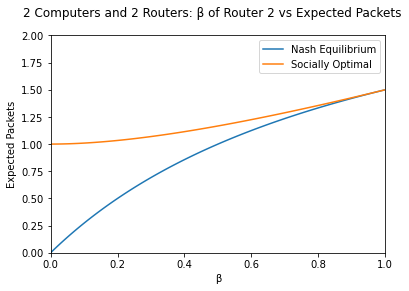

In [11]:
fig, ax = plt.subplots()

mapper = lambdify(beta, total_packets, modules=['numpy'])
xs = np.linspace(0, 1, 100)
ys = mapper(xs)
plt.plot(xs, ys, label="Nash Equilibrium")

mapper = lambdify(beta, total_packets_optimal, modules=['numpy'])
xs = np.linspace(0, 1, 100)
ys = mapper(xs)
plt.plot(xs, ys, label="Socially Optimal")

fig.suptitle("2 Computers and 2 Routers: β of Router 2 vs Expected Packets")
ax.legend()
plt.xlabel("β")
plt.ylabel("Expected Packets")
ax.set_xlim(0,1)
ax.set_ylim(0,2)

plt.show()

Clearly, the Nash equilibrium expected packet count converges to that of the socially optimal solution. This is because as the efficiency of the second router improves, computers become less averse to the second router. Eventually, both routers are equally efficient, and computers will automatically tend to choosing one with equal probability the same as the socially optimal solution would give.

This means that for a 2 computer 2 router setup, the "price of anarchy" decreases with respect to the efficiencies of the routers.

We can also draw a graph of what happens to expected packets when computers choose arbitrary values of $\pi$. For this, we'll plot the expected packet function itself with $\pi$ on the x-axis and $\beta$ on the time axis. In other words, the graph is three-dimensional with time as the third axis. In order to accomplish this, we first import Pillow, which is an image-handling package for Python. We also need BytesIO to store the resulting images in memory.

In [12]:
from io import BytesIO
from PIL import Image, ImageDraw
# ImageDraw will be used later on


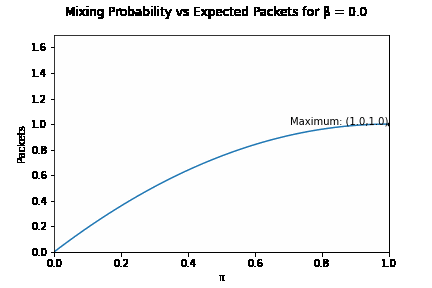

<Figure size 432x288 with 0 Axes>

In [13]:
images = []
for beta in np.linspace(0, 1, 20):
    expected = total_packet_function.subs(symbols("beta"), beta)
    mapper = lambdify(pi, expected, modules=['numpy'])
    xs = np.linspace(0, 1, 100)
    ys = mapper(xs)
    plt.clf()
    fig, ax = plt.subplots()
    plt.plot(xs, ys)

    fig.suptitle(f"Mixing Probability vs Expected Packets for β = {round(beta, 2)}")
    plt.xlabel("π")
    plt.ylabel("Packets")
    ax.set_xlim([0,1])
    ax.set_ylim([0,1.7])

    soln = social_pi.subs(symbols("beta"), beta)
    value = expected.subs(pi, soln)
    plt.plot([soln], [value], '.', color = "black")
    ax.text(soln, value, f"Maximum: ({round(float(soln), 2)},{round(float(value), 2)})", horizontalalignment=['left', 'right'][float(soln) > 0.5])

    pinashval = nash_pi.subs(symbols("beta"), beta)
    nashpackets = expected.subs(pi, pinashval)
    plt.plot([pinashval], [nashpackets], '.', color = "black")
    ax.text(pinashval, nashpackets, f"Nash Eq: ({round(float(pinashval), 2)},{round(float(nashpackets), 2)})", horizontalalignment=['left', 'right'][float(pinashval) > 0.5], verticalalignment="top")
    filex = BytesIO()
    fig.savefig(filex, format = "png")
    plt.close()
    filex.seek(0)
    images.append(filex)

imgs = [Image.open(image) for image in images]
masterfilex = BytesIO()
imgs[0].save(fp=masterfilex, format='GIF', append_images=imgs[1:], save_all=True, duration=600, loop=0)

# this is a GIF-displaying hack from https://stackoverflow.com/a/32108899
from IPython.display import HTML
from base64 import b64encode
HTML("<img src='data:image/gif;base64,{0}'/>".format(b64encode(masterfilex.getvalue()).decode('utf-8')))

As $\beta$ increases, the disparity between the Nash equilibrium and the socially optimal packet counts becomes smaller and smaller. It also becomes clear here that the socially optimal solution really is a maximum.

## Adding More Computers

We now make our first extension of the model beyond the basic result. We've seen what happens when we have two computers, but what about when we have three? Or four?

One would think that if there are more computers in a system that doesn't increase in size to support these computers, the probability of sharing the same router becomes much higher. Additionally, the total expected number of packets is still constrained by the fact that there are only two routers, so much more packets would be expected to be dropped.

We can find the solution to this problem using Python and a bit of extra theory. First, we must define the nature of the problem when we have an arbitrary number of computers.

Every player is able to select from one of the two routers available to them. We continue to use $\pi$ to represent the probability of them choosing a particular router.

There are two major changes to the model. The first is that for any given router, if more than one computer is using it, each computer would get payoff $\frac{1}{k}$ where $k$ is the number of computers using the router. For example, if we had 5 computers using Router 1, each would have an expected number of packets processed of $\frac{1}{5}$. Similarly, if we had 3 computers using Router 2, each would have an expected number of packets processed of $\frac{\beta}{3}$. This extends the existing model where if 2 computers used the same router, they each get half of the total expected processing capability of the router.

The second is that when we compute the system of equations which need to be solved to make opposing computers indifferent to choosing a particular router, we must now account for the choices of multiple other computers instead of just one. What this means is that instead of just having a linear equation in terms of the choice $\pi$ of one computer, we have a polynomial equation in terms of the choice $\pi$ of all the other computers. We assume everyone uses the same equilibrium $\pi$ since the game is still symmetric.

This amounts to having the i-th computer determining whether the set of payoffs used comes from the subset of the game where the i-th computer chooses Router 1 or whether it comes from the other. For example, if we had three computers, the expected payoff for one of them, choosing Router 1, would be equal to:

$$[\frac{1}{3}\pi + \frac{1}{2}(1-\pi)]\pi + [\frac{1}{2}\pi + 1(1-\pi)](1-\pi)$$

Note how we see a payoff coefficient of $\frac{1}{3}$ to represent the case where all three computers use the same router, and $\frac{1}{2}$ in cases where this computer shares a router with just one other. These payoffs were determined by physically drawing out the entire game, which is left as an exercise to the reader.

We could easily extend this representation to account for four computers. Once again, the full table is not shown here due to the large size of the resulting game. We receive an expected payoff from choosing Router 1 of:

$${[\frac{1}{4}\pi + \frac{1}{3}(1-\pi)]\pi + [\frac{1}{3}\pi + \frac{1}{2}(1-\pi)](1-\pi)}\pi + {[\frac{1}{3}\pi + \frac{1}{2}(1-\pi)]\pi + [\frac{1}{2}\pi + 1(1-\pi)](1-\pi)}(1-\pi)$$

The same operation can be done for a set of five computers, but is not represented here. Instead, we observe what happens when we simplify the resulting equation. While we could use Sympy for this, it is not capable of representing the equation form we need. Instead, this is done manually and left as an exercise to the reader. For 3 computers, we get:

$$1*\frac{1}{3}\pi^2 + 2*\frac{1}{2}(1-\pi)\pi + 1*(1-\pi)^2$$

For 4 computers, we get:

$$1*\frac{1}{4}\pi^3 + 3*\frac{1}{3}\pi^2(1-\pi) + 3*\frac{1}{2}(1-\pi)^2\pi + 1*(1-\pi)^3$$

On paper, the result for 5 computers was calculated, but is not shown here due to size. However, note the result given by 2 computers:

$$1*\frac{1}{2}\pi + 1*(1-\pi)$$

The whole number coefficients of these three equations form the entries of Pascal's Triangle for the second, third and fourth rows, respectively. Proving this involves induction on the number of computers, which is left as another exercise to the reader.

As a result, in the general case, we can define the expected payoff from choosing Router 1 in an $n+1$ computer setup setup to be:

$$\sum_{k=0}^n (\frac{1}{n-k+1}{n \choose k}\pi^{n-k}(1-\pi)^k)$$

We use $n+1$ as the number of computers to make working with the exponents easier. 

This equation also occurs in a modified form when running the above computations for choosing the second router. As an example, the 3 computer setup gives:

$$1*\beta\pi^2 + 2*\frac{\beta}{2}(1-\pi)\pi + \frac{\beta}{3}*(1-\pi)^2$$

A simple modification of the expected payoff sum thus gives:

$$\sum_{k=0}^n (\frac{\beta}{k+1}{n \choose k}\pi^{n-k}(1-\pi)^k$$

where $n+1$ is the number of computers.

Now that we have our two expressions for the expected payoffs of a particular player, we can equate them to try and find the Nash equilibrium value of $\pi$.

Unfortunately, Sympy was not able to simplify the first sum so instead, we use [WolframAlpha](https://www.wolframalpha.com/).

$$\sum_{k=0}^n (\frac{1}{n-k+1}{n \choose k}\pi^{n-k}(1-\pi)^k) = \frac{(-1)^{n+1}(\pi-1)^n + \pi(1-\pi)^n + 1}{\pi(n+1)}$$

We do the same to the second sum:

$$\sum_{k=0}^n (\frac{\beta}{k+1}{n \choose k}\pi^{n-k}(1-\pi)^k = \frac{\beta(\pi^{n+1} - 1)}{(\pi-1)(n+1)}$$

In [14]:
n, beta = symbols("n beta")
eq1 = ((-1)**(n+1)*(pi-1)**n + pi*(1-pi)**n + 1)/(pi*(n+1))
eq2 = (beta*(pi**(n+1) - 1))/((pi-1)*(n+1))
eq1-eq2

-beta*(pi**(n + 1) - 1)/((n + 1)*(pi - 1)) + ((-1)**(n + 1)*(pi - 1)**n + pi*(1 - pi)**n + 1)/(pi*(n + 1))

For unknown reasons, attempting to use Sympy to simplify this with a particular given $n$ returns different equations than using SageMath directly. Thus, SageMath was used directly. This was the result for attempting to run $n = 6$:

$$\left[0 = {\left(\beta - 1\right)} \pi^{6} + {\left(\beta + 7\right)} \pi^{5} + {\left(\beta - 21\right)} \pi^{4} + {\left(\beta + 35\right)} \pi^{3} + {\left(\beta - 35\right)} \pi^{2} + {\left(\beta + 21\right)} \pi + \beta - 7\right]$$

This was the result for $n = 7$:

$$\left[0 = {\left(\beta + 1\right)} \pi^{7} + {\left(\beta - 8\right)} \pi^{6} + {\left(\beta + 28\right)} \pi^{5} + {\left(\beta - 56\right)} \pi^{4} + {\left(\beta + 70\right)} \pi^{3} + {\left(\beta - 56\right)} \pi^{2} + {\left(\beta + 28\right)} \pi + \beta - 8\right]$$

Upon careful examination, these constants are also binomial coefficients, meaning these expressions can be encapsulated in a summation form. This form is:

$$\sum_{k = 0}^n ((\beta - (-1)^k) {n+1 \choose k+1} \pi^k)$$

We can use this general form to try and solve the equation for $\pi$. However, solving the equation requires knowledge of a serious issue with attempting to find the roots of polynomials with degree 5 or more: there is no closed form solution for them. Special methods have to be used in order to find these roots, and here we use Newton's method of polynomial root approximation. This method involves taking a starting guess, say $\pi = \beta$, and evaluating the function and its derivative at this guess. This returns a delta value which we subtract from the guess to obtain a new guess. We compute:

$$x_1 = x_0 - \frac{f(x_0)}{f'(x_0)}$$

We loop this procedure until our delta value is small enough for the guess to be considered correct, or until too many iterations have been conducted.

Since this gives a numerical result, we can plot it. Here we use Matplotlib to plot the results for the basic 2 computer scenario.


In [15]:
def get_guesses(n):
    n = n-1
    pi, beta = symbols("pi beta")
    equation = sum((beta - (-1)**k * binomial(n+1, k+1)) * pi**k for k in range(0, n+1))
    eqdiff = diff(equation, pi)
    guesses = []
    for beta in np.append(np.linspace(1/(n+1), 1, 20)[:-1], 0.99999999):
        cur_guess = beta
        while True:
            new_cur_guess = simplify(cur_guess - (simplify(equation.subs(pi, cur_guess).subs(symbols("beta"), beta)) 
                                                  / simplify(eqdiff.subs(pi, cur_guess).subs(symbols("beta"), beta))))

            if abs(new_cur_guess - cur_guess) <= 0.001:
                break

            cur_guess = new_cur_guess

        guesses.append(re(cur_guess))
    return guesses
    
myguesses = get_guesses(2)
myguesses

[1.00000000000000,
 0.965517241379310,
 0.932203389830509,
 0.900000000000000,
 0.868852459016394,
 0.838709677419355,
 0.809523809523810,
 0.781250000000000,
 0.753846153846154,
 0.727272727272727,
 0.701492537313433,
 0.676470588235294,
 0.652173913043478,
 0.628571428571429,
 0.605633802816901,
 0.583333333333333,
 0.561643835616438,
 0.540540540540541,
 0.520000000000000,
 0.500000007500000]

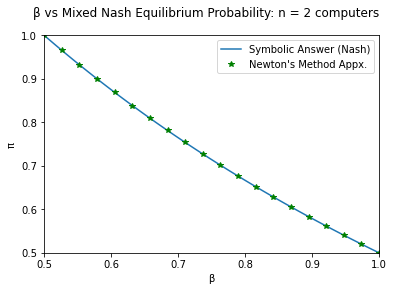

In [16]:
def display_guesses(guesses, n):
    fig, ax = plt.subplots()
    space = np.append(np.linspace(1/(n), 1, 20)[:-1], 0.99999999)
    beta = symbols("beta")
    if n == 2:
        exp = (2-beta)/(1+beta)
        label = 'Symbolic Answer (Nash)'
        mapper = lambdify(beta, exp, modules=['numpy'])
        xs = np.linspace(0, 1, 100)
        ys = mapper(xs)
        plt.plot(xs, ys, label=label)
    else:
        plt.plot(space, guesses, label = 'Direct Fit')
        
    title = f"β vs Mixed Nash Equilibrium Probability: n = {n} computers"
    label = 'Newton\'s Method Appx.'
    plt.plot(space, guesses, "*", color = "green", label = label)
    fig.suptitle(title)
    ax.legend()
    plt.xlabel("β")
    plt.ylabel("π")
    ax.set_xlim([1/(n),1])
    ax.set_ylim([0.5, 1])
    plt.show()
    
display_guesses(myguesses, 2)

We can also try for $n = 3$ or even $n = 20$.

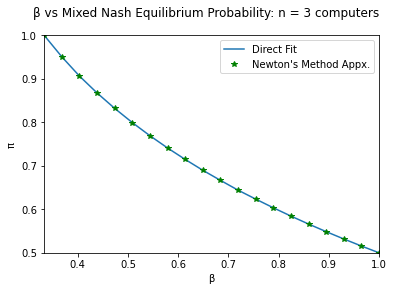

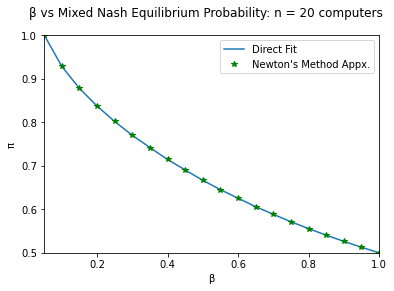

In [17]:
display_guesses(get_guesses(3), 3)
display_guesses(get_guesses(20), 20)

Next, we can obtain the data for the socially optimal general solution. This involves finding the general formula for total expected number of packets and maximizing it.

The expected number of packets is the expectation over every outcome of the game. For 2 computers, we have:

$$\pi^2(\frac{1}{2}+\frac{1}{2}) + 2\pi(1-\pi)(1+\beta) + (\frac{\beta}{2}+\frac{\beta}{2})(1-\pi)^2 = \pi^2 + 2\pi(1-\pi)(1+\beta)+\beta(1-\pi)^2$$

For 3 computers, we have the following:

$$\pi^3(\frac{1}{3}+\frac{1}{3}+\frac{1}{3}) + \pi^2(1-\pi)(\frac{1}{2}+\frac{1}{2}+\beta)*3 + 3*\pi(1-\pi)^2(1+\frac{\beta}{2}+\frac{\beta}{2}) + (\frac{\beta}{3} + \frac{\beta}{3} + \frac{\beta}{3})(1-\pi)^3$$

This simplifies to

$$\pi^3 + 3\pi^2(1-\pi)(1+\beta)+3\pi(1-\pi)^2(1+\beta) + \beta(1-\pi)^3$$

Without proving, we can predict that this also appears to be framed around a binomial coefficient sequence. However, the first and last terms are different due to each having one router unused entirely, and so the general sum must account for this. We therefore get:

$$\pi^n + \sum_{k = 1}^{n-1} ((1+\beta){n \choose k}\pi^{n-k}(1-\pi)^k) + \beta(1-\pi)^n$$

where this time $n$ is the number of computers in the game.

Using WolframAlpha again, the closed form of this sum is:

$$\pi^n - (\beta + 1)((1-\pi)^n + \pi^n - 1) + \beta(1-\pi)^n$$

so we can differentiate this and maximize it to find the socially optimal $\pi$.

In [18]:
pi, beta, n = symbols("pi beta n")
exp = diff(pi**n - (beta + 1)*((1-pi)**n + pi**n - 1) + beta*(1-pi)**n, pi)
# delete common terms and negate since we are equating to zero and they will not matter
-1*expand(exp.subs(n, 6))/6 

beta*pi**5 + pi**5 - 5*pi**4 + 10*pi**3 - 10*pi**2 + 5*pi - 1

In [19]:
-1*expand(exp.subs(n, 7))/7 

beta*pi**6 - pi**6 + 6*pi**5 - 15*pi**4 + 20*pi**3 - 15*pi**2 + 6*pi - 1

With the exception of the first term, this sequence is a simple polynomial with binomial coefficients. This can be encapsulated as:

$$\beta\pi^{n-1} + \sum_{k = 0}^{n-1} ((-1)^{k+1}{n-1 \choose k}\pi^k)$$

which allows us to apply Newton's method again.

In [20]:
def get_optimal_guesses(n):
    pi, beta = symbols("pi beta")
    equation = sum((-1)**(k+1) * pi**k * binomial(n-1, k) for k in range(0, n)) + beta*pi**(n-1)
    eqdiff = diff(equation, pi)
    guesses = []
    for beta in np.append(np.linspace(0, 1, 40)[:-1], 0.99999999):
        cur_guess = beta
        while True:
            new_cur_guess = simplify(cur_guess - (simplify(equation.subs(pi, cur_guess).subs(symbols("beta"), beta)) 
                                                  / simplify(eqdiff.subs(pi, cur_guess).subs(symbols("beta"), beta))))

            if abs(new_cur_guess - cur_guess) <= 0.001:
                break

            cur_guess = new_cur_guess

        guesses.append(re(cur_guess))
    return guesses
    
myguesses = get_optimal_guesses(2)
myguesses

[1.00000000000000,
 0.975000000000000,
 0.951219512195122,
 0.928571428571429,
 0.906976744186046,
 0.886363636363636,
 0.866666666666667,
 0.847826086956522,
 0.829787234042553,
 0.812500000000000,
 0.795918367346939,
 0.780000000000000,
 0.764705882352941,
 0.750000000000000,
 0.735849056603774,
 0.722222222222222,
 0.709090909090909,
 0.696428571428571,
 0.684210526315789,
 0.672413793103448,
 0.661016949152542,
 0.650000000000000,
 0.639344262295082,
 0.629032258064516,
 0.619047619047619,
 0.609375000000000,
 0.600000000000000,
 0.590909090909091,
 0.582089552238806,
 0.573529411764706,
 0.565217391304348,
 0.557142857142857,
 0.549295774647887,
 0.541666666666667,
 0.534246575342466,
 0.527027027027027,
 0.520000000000000,
 0.513157894736842,
 0.506493506493507,
 0.500000002500000]

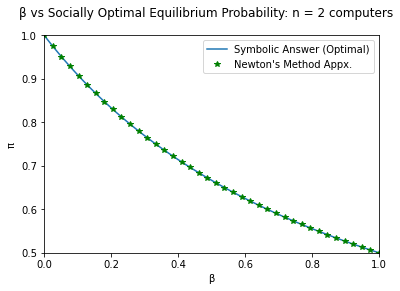

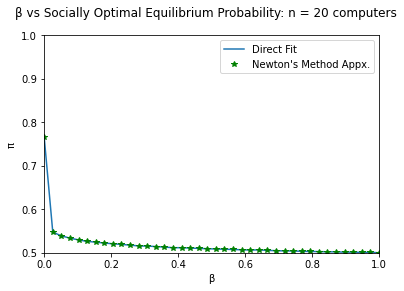

In [21]:
def display_optimal_guesses(guesses, n):
    fig, ax = plt.subplots()
    space = np.append(np.linspace(0, 1, 40)[:-1], 0.99999999)
    beta = symbols("beta")
    if n == 2:
        exp = 1/(1+beta)
        label = 'Symbolic Answer (Optimal)'
        mapper = lambdify(beta, exp, modules=['numpy'])
        xs = np.linspace(0, 1, 100)
        ys = mapper(xs)
        plt.plot(xs, ys, label=label)
    else:
        plt.plot(space, guesses, label = 'Direct Fit')
        
    title = f"β vs Socially Optimal Equilibrium Probability: n = {n} computers"
    label = 'Newton\'s Method Appx.'
    plt.plot(space, guesses, "*", color = "green", label = label)
    fig.suptitle(title)
    ax.legend()
    plt.xlabel("β")
    plt.ylabel("π")
    ax.set_xlim([0,1])
    ax.set_ylim([0.5, 1])
    plt.show()
    
display_optimal_guesses(myguesses, 2)
display_optimal_guesses(get_optimal_guesses(20), 20)

We see very different behaviour in terms of the graph's shifting as $n$ increases. To quantify this, we apply the resulting $\pi$ data to the expected packets function and display everything in one graph.

In [ ]:
print("Working...")
images = []
for n in range(2, 21):
    pi, beta = symbols("pi beta")
    equation = sum((-1)**(k+1) * pi**k * binomial(n-1, k) for k in range(0, n-1)) + (beta + (-1)**n)*pi**(n-1)
    eqdiff = diff(equation, pi)
    packetcounter = beta + 1 - beta*pi**n - (1-pi)**n
    packetcounter2 = beta + 1 - beta*pi**(n+1) - (1-pi)**(n+1)

    guesses = []
    for beta in np.append(np.linspace(0, 1, 40)[:-1], 0.99999999):
        cur_guess = beta
        while True:
            new_cur_guess = simplify(cur_guess - (simplify(equation.subs(pi, cur_guess).subs(symbols("beta"), beta)) / simplify(eqdiff.subs(pi, cur_guess).subs(symbols("beta"), beta))))
            if abs(new_cur_guess - cur_guess) <= 0.001:
                break

            cur_guess = new_cur_guess

        pc = packetcounter
        guesses.append(simplify(pc.subs(pi, re(cur_guess)).subs(symbols("beta"), beta)))

    guesses2 = []
    nx = n - 1
    equation = sum((symbols("beta") - (-1)**k * binomial(nx+1, k+1)) * pi**k for k in range(0, nx+1))
    eqdiff = diff(equation, pi)
    for beta in np.append(np.linspace(1/(nx+1), 1, 20)[:-1], 0.99999999):
        cur_guess = beta
        while True:
            new_cur_guess = simplify(cur_guess - (simplify(equation.subs(pi, cur_guess).subs(symbols("beta"), beta)) / simplify(eqdiff.subs(pi, cur_guess).subs(symbols("beta"), beta))))
            if abs(new_cur_guess - cur_guess) <= 0.001:
                break

            cur_guess = new_cur_guess

        guesses2.append(simplify(packetcounter.subs(pi, re(cur_guess)).subs(symbols("beta"), beta)))

    plt.clf()
    fig, ax = plt.subplots()
    space = np.append(np.linspace(0, 1, 40)[:-1], 0.99999999)
    space2 = np.append(np.linspace(1/(n), 1, 20)[:-1], 0.99999999)
    plt.plot(space, guesses, label = 'Direct Fit (Optimal)')
    plt.plot(space2, guesses2, label = 'Direct Fit (Nash)')
    title = f"β vs Optimal and Nash Packet Count: n = {n} computers"
    label = 'Newton\'s Method Appx. (Optimal)'
    plt.plot(space, guesses, "*", color = "green", label = label)
    plt.plot(space2, guesses2, "*", color = "purple", label = 'Newton\'s Method Appx. (Nash)')

    fig.suptitle(title)
    ax.legend()
    plt.xlabel("β")
    plt.ylabel("Expected Packets")
    ax.set_xlim([0,1])
    ax.set_ylim([0,2])
    filex = BytesIO()
    fig.savefig(filex, format = "png")
    filex.seek(0)
    plt.close()
    images.append(filex)
    print(f"{n - 1} of 19 complete")

imgs = [Image.open(image) for image in images]
masterfilex = BytesIO()
imgs[0].save(fp=masterfilex, format='GIF', append_images=imgs[1:], save_all=True, duration=200, loop=0)
masterfilex.seek(0)
  
# this is a GIF-displaying hack from https://stackoverflow.com/a/32108899
from IPython.display import HTML
from base64 import b64encode
HTML("<img src='data:image/gif;base64,{0}'/>".format(b64encode(masterfilex.getvalue()).decode('utf-8')))

Working...
1 of 19 complete
2 of 19 complete
3 of 19 complete
4 of 19 complete
5 of 19 complete
6 of 19 complete
7 of 19 complete
8 of 19 complete
9 of 19 complete
10 of 19 complete
11 of 19 complete
12 of 19 complete
13 of 19 complete
14 of 19 complete
15 of 19 complete


This graph shows that as the number of computers increases, the performance of the unregulated network trends towards that of the regulated network. We can figure out exactly how much this shrinks by plotting the difference between the socially optimal and Nash equilibrium solutions for various values of $\beta$ on the time axis given number of computers on the x axis.

In [ ]:
images = []
ns = []
for n in range(2, 21):
    pi, beta = symbols("pi beta")
    equation = sum((-1)**(k+1) * pi**k * binomial(n-1, k) for k in range(0, n-1)) + (beta + (-1)**n)*pi**(n-1)
    eqdiff = diff(equation, pi)
    packetcounter = beta + 1 - beta*pi**n - (1-pi)**n

    guesses = []
    for beta in np.append(np.linspace(1/(n+1), 1, 40)[:-1], 0.99999999):
        cur_guess = beta
        while True:
            new_cur_guess = simplify(cur_guess - (simplify(equation.subs(pi, cur_guess).subs(symbols("beta"), beta)) / simplify(eqdiff.subs(pi, cur_guess).subs(symbols("beta"), beta))))
            if abs(new_cur_guess - cur_guess) <= 0.001:
                break

            cur_guess = new_cur_guess

        guesses.append(simplify(packetcounter.subs(pi, re(cur_guess)).subs(symbols("beta"), beta)))

    guesses2 = []
    nx = n - 1
    equation = sum((symbols("beta") - (-1)**k * binomial(nx+1, k+1)) * pi**k for k in range(0, nx+1))
    eqdiff = diff(equation, pi)
    for beta in np.append(np.linspace(1/(n+1), 1, 40)[:-1], 0.99999999):
        cur_guess = beta
        while True:
            new_cur_guess = simplify(cur_guess - (simplify(equation.subs(pi, cur_guess).subs(symbols("beta"), beta)) / simplify(eqdiff.subs(pi, cur_guess).subs(symbols("beta"), beta))))
            if abs(new_cur_guess - cur_guess) <= 0.001:
                break

            cur_guess = new_cur_guess

        guesses2.append(simplify(packetcounter.subs(pi, re(cur_guess)).subs(symbols("beta"), beta)))

    disparities = [g1-g2 for g1, g2 in zip(guesses, guesses2)]
    ns.append(disparities)
    print(f"{n - 1} of 19 complete: part 1 of 2")

i = 0
for beta in np.append(np.linspace(1/(n+1), 1, 40)[:-1], 0.99999999):
    plt.clf()
    fig, ax = plt.subplots()
    plt.plot(range(2, 21), [disp[i] for disp in ns], label = 'Disparity')
    plt.fill_between(np.array(range(2, 21), dtype=float), np.array([disp[i] for disp in ns], dtype=float))
    fig.suptitle(f"Computers vs Opt/Nash Disparity: β = {round(beta, 2)}")
    ax.legend()
    plt.xlabel("Computers")
    plt.ylabel("Disparity (Packets)")
    ax.set_xlim(2,20)
    ax.set_ylim(0,0.5)
    filex = BytesIO()
    fig.savefig(filex, format = "png")
    filex.seek(0)
    plt.close()
    images.append(filex)
    print(f"{i + 1} of 40 complete: part 2 of 2")
    i += 1
        

imgs = [Image.open(image) for image in images]
masterfilex = BytesIO()
imgs[0].save(fp=masterfilex, format='GIF', append_images=imgs[1:], save_all=True, duration=200, loop=0)
masterfilex.seek(0)

# this is a GIF-displaying hack from https://stackoverflow.com/a/32108899
from IPython.display import HTML
from base64 import b64encode
HTML("<img src='data:image/gif;base64,{0}'/>".format(b64encode(masterfilex.getvalue()).decode('utf-8')))

Thus, we see that as the number of computers increases, the disparity between the solutions decreases relatively exponentially. As $\beta$ increases, the disparity also decreases in a similar way.

## Adding More Routers

Now that we've seen the results of adding more computers, we explore the results of adding more routers to the initial problem. In this scenario, we have 2 computers in the game, and an arbitrary set of routers, each with its own probability $\beta_i$ of processing a packet. Here, we expect to see the expected number of packets processed increase with the number of routers as having more routers decreases the chance of collisions between the two computers using them.



We modify the original scenario as follows. First, every router is given a probability $\beta_i$ of processing any particular packet, as above.

Next, each computer now has to make a decision about the probability by which to choose all of the available routers. Each router has an associated choice probability $\pi_i$ by which a computer will choose that router. We therefore have that $\sum_{i = 0}^m \pi_i = 1$ given $m$ routers. 

In a scenario with three routers, we have the following game matrix:

| C1 \|    C2| Router 1 | Router 2     | Router 3|
| :---        |    :----:   |      :----:   |       :---: |
| **Router 1**   | $\frac{\beta_1}{2}$, $\frac{\beta_1}{2}$ | $\beta_1$, $\beta_2$   | $\beta_1$, $\beta_3$   |
| **Router 2**   | $\beta_2$, $\beta_1$    | $\frac{\beta_2}{2}$, $\frac{\beta_2}{2}$      |$\beta_2$, $\beta_3$   |
| **Router 3**   | $\beta_3$, $\beta_1$  | $\beta_3$, $\beta_2$      |$\frac{\beta_3}{2}$, $\frac{\beta_3}{2}$   |

Since we have three routers, a particular computer needs to make their opponent indifferent between choosing all three, meaning we must have equalities among the expected payoffs of all three routers.

Thus, we see:

$$\frac{\beta_1}{2}\pi_1 + \beta_1\pi_2 + \beta_1\pi_3 = \beta_2\pi_1 + \frac{\beta_2}{2}\pi_2 + \beta_2\pi_3 = \beta_3\pi_1 + \beta_3\pi_2 + \frac{\beta_3}{2}\pi_3$$

Similarly, in a genralized two router game with beta values for both routers, we would have:

$$\frac{\beta_1}{2}\pi_1 + \beta_1\pi_2 = \beta_2\pi_1 + \frac{\beta_2}{2}\pi_2$$

where $\pi_1 + \pi_2$ = 1. Thus, it becomes clear what the general form of the system of equations is. Given this, we can formulate a matrix to solve it.

The general setup of the i-th expression is:

$$\beta_i(\pi_1+\pi_2+...+\pi_m) - \frac{\beta_i}{2}\pi_i = \beta_i-\frac{\beta_i\pi_i}{2}$$

Using the first expression as an anchor, we create a set of equations to solve. This gives two resulting equations for the three router setup:

$$\beta_1-\frac{\beta_1\pi_1}{2} - \beta_2+\frac{\beta_2\pi_2}{2}= 0$$
$$\beta_1-\frac{\beta_1\pi_1}{2} - \beta_3+\frac{\beta_3\pi_3}{2}= 0$$

Rearranging and adding the constraint that the $\pi$ variables sum to 1, we get:

$$
\begin{bmatrix}
-\frac{\beta_1}{2} & \frac{\beta_2}{2} & 0\\
-\frac{\beta_1}{2} & 0 & \frac{\beta_3}{2}\\
1 & 1 & 1
\end{bmatrix} \begin{bmatrix}
\pi_1\\
\pi_2\\
\pi_3
\end{bmatrix} = \begin{bmatrix}
\beta_2 - \beta_1\\
\beta_3 - \beta_1\\
1
\end{bmatrix}
$$

In general, every $i$-th row of the matrix has $\frac{\beta_{i+1}}{2}$ in the $i+1$-th position, and the $i$-th entry of the solution vector is $\beta_{i+1} - \beta_1$. Thus, we can generate a setup for any particular number of routers.

We can use Sympy's symbolic matrix equation solver to solve a general set of these equations for particular values of $\pi_i$.

In [ ]:
from sympy.matrices import Matrix
from IPython.display import display, Math

def nash_pis(routers):
    betas = symbols(" ".join([f'beta{i}' for i in range(1, routers + 1)]))

    Amatrix = []
    for i in range(routers - 1):
        newlist = [-betas[0]/2] + [0 for j in range(1, routers)]
        newlist[i+1] = betas[i+1]/2
        Amatrix.append(newlist)

    Amatrix.append([1 for i in range(routers)])
    A = Matrix(Amatrix)

    bvector = []
    for i in range(1, routers):
        bvector.append(betas[i] - betas[0])

    bvector.append(1)
    b = Matrix(routers, 1, bvector)
    x = A.LUsolve(b)
    return [simplify(a) for a in x]

for a in nash_pis(2):
    display(Math(latex(a)))

In [ ]:
for a in nash_pis(3):
    display(Math(latex(a)))

This data is not particularly easy to generalize so instead we can directly put this into the expected packets function. Expected packets is still the sum of expected values of each outcome for the entire game, and now that the beta variables correspond to the pi variables, we can encapsulate this formulaicly.

In [ ]:
routers = 3
betas = symbols(" ".join([f'beta{i}' for i in range(1, routers + 1)]))
pis = symbols(" ".join([f'pi{i}' for i in range(1, routers + 1)]))
packetcounter = sum(simplify(betas[i] * pis[i]**2) for i in range(routers)) + \
    sum(simplify(sum(simplify(2*pis[i]*pis[j]*(betas[i]+betas[j])) for j in range(i))) for i in range(1, routers))

simplify(packetcounter)

Note we multiply each term in the second component by 2 because the game is symmetric, so we only really need to worry about one half of the payoff set.

Finally, we can try plugging the Nash equilibrium $\pi$ values into the expected packets function.

In [ ]:
pis = nash_pis(3)
packetcounter = sum(simplify(betas[i] * pis[i]**2) for i in range(routers)) + \
    sum(simplify(sum(simplify(2*pis[i]*pis[j]*(betas[i]+betas[j])) for j in range(i))) for i in range(1, routers))

simplify(packetcounter)

In [ ]:
routers = 2
pis = nash_pis(2)
packetcounter = sum(simplify(betas[i] * pis[i]**2) for i in range(routers)) + \
    sum(simplify(sum(simplify(2*pis[i]*pis[j]*(betas[i]+betas[j])) for j in range(i))) for i in range(1, routers))

simplify(packetcounter)

Note this second function is the original expected packet function at Nash equilibrium adjusted so that the first router had its own $\beta$. If one sets $\beta_1 = 1$ and $\beta_2 = \beta$, we see this original function.

In [ ]:
routers = 4
pis = nash_pis(4)
betas = symbols(" ".join([f'beta{i}' for i in range(1, routers + 1)]))
packetcounter = sum(simplify(betas[i] * pis[i]**2) for i in range(routers)) + \
    sum(simplify(sum(simplify(2*pis[i]*pis[j]*(betas[i]+betas[j])) for j in range(i))) for i in range(1, routers))

simplify(packetcounter)

There is an obvious pattern here where the numerator has a coefficient that increments by 2 for every additional router, and that the denominator is the set of all combinations of the numbers from 1 to `routers` of length `routers - 1`.

In [ ]:
import itertools

def packets_nash(routers):
    betas = symbols(" ".join([f'beta{i}' for i in range(1, routers + 1)]))
    return (2*routers - 1) * np.prod(betas) / \
                (sum(np.prod(i) for i in itertools.combinations(betas, routers - 1)))

packets_nash(2)

In [ ]:
packets_nash(3)

We see the same results as before, albeit computed much faster as we no longer need to solve a symbolic matrix system.

Now that we have the results for the Nash equilibrium, we can find the results for the socially optimal solution. To do this, we maximize the expected packets function for a particular set of routers. We accomplish this in Python using SciPy's minimize function. Unfortunately, this is a numerical function, meaning we cannot provide a general solution. We can, however, declare a few values of $\beta_i$ to test it with.

We also add the constraint that each $\pi$ is non-negative. This is because if we did not have this constraint, select $\pi$ values in higher dimensions tended to become negative, which resulted in impossible scenarios.

In [ ]:
import scipy.optimize as optimize
from scipy.optimize import LinearConstraint, Bounds

def pis_optimal(betas):
    routers = len(betas)

    def f(pis):
        nonlocal betas, routers
        return -1 * (sum(betas[i]*pis[i]**2 for i in range(routers)) + 2 * (sum(pis[r[0]]*pis[r[1]]*(betas[r[0]]+betas[r[1]]) for r in itertools.combinations(range(routers), 2))))

    res = optimize.minimize(f, [1/routers for i in range(routers)], constraints=[LinearConstraint([np.ones(routers)], [1], [1])], bounds = Bounds(np.zeros(routers), np.inf * np.ones(routers)))
    return res.x

pis_optimal([0.1, 0.2, 0.3])

In [ ]:
pis_optimal([1, 1])

In [ ]:
pis_optimal([1, 1, 1, 0])

We have some clear results, so we can generate some expected packets data for them. To be more comprehensive, we'll plot this data along with the data for the Nash equilibrium results on a graph.

In [ ]:
def graph_packets(basebetas):
    betas = basebetas + [symbols("beta")]
    routers = len(betas)

    equation2 = (2*routers - 1) * np.prod(betas) / (sum(np.prod(i) for i in itertools.combinations(betas, routers - 1)))
    plt.clf()
    fig, ax = plt.subplots()

    mapper = lambdify(betas[-1], equation2, modules=['numpy'])
    xs = np.linspace(0, 1, 100)
    ys = mapper(xs)
    plt.plot(xs, ys, label="Nash Equilibrium")

    def f(pis):
        nonlocal newbetas, routers
        return -1 * (sum(newbetas[i]*pis[i]**2 for i in range(routers)) + 2 * (sum(pis[r[0]]*pis[r[1]]*(newbetas[r[0]]+newbetas[r[1]]) for r in itertools.combinations(range(routers), 2))))
    
    newbetas = []
    expected_packets = []
    for beta in np.linspace(0, 1, 100):
        newbetas = basebetas + [beta]
        res = optimize.minimize(f, [1/routers for i in range(routers)], constraints=[LinearConstraint([np.ones(routers)], [1], [1])], bounds = Bounds(np.zeros(routers), np.inf * np.ones(routers)))
        mpis = res.x
        expected_packets.append(sum(newbetas[i]*mpis[i]**2 for i in range(routers)) + 2 * (sum(mpis[r[0]]*mpis[r[1]]*(newbetas[r[0]]+newbetas[r[1]]) for r in itertools.combinations(range(routers), 2))))

    plt.plot(np.linspace(0, 1, 100), expected_packets, label="Socially Optimal")

    fig.suptitle(f"2 ComputersNow and {len(betas)} routers: β in {[round(beta, 2) for beta in betas[:-1]]} + variable")
    ax.legend()
    plt.xlabel("β (variable router)")
    plt.ylabel("Expected Packets")
    ax.set_xlim(0,1)
    ax.set_ylim(0,2)
    filex = BytesIO()
    fig.savefig(filex, format = "png")
    filex.seek(0)
    plt.show()
    
graph_packets([1])

This is the original graph, once again.

In [ ]:
graph_packets([1, 1])

In [ ]:
graph_packets([1, 1, 1, 1, 1])

As we add additional high-efficiency routers, the expected number of packets greatly increases, although so does the benefit of having regulation, which is better able to handle the one less-efficient router. Now, we add more less-efficient routers.

In [ ]:
graph_packets([0.5, 0.5, 0.5, 0.5, 0.5])

When the average efficiency is further away from perfect, the point at which the Nash equilibrium and the socially optimal solutions converge becomes said average efficiency. This is because once the Nash probability is to have an equal chance of choosing any one router, no regulation is necessary as we have encountered before.

In [ ]:
graph_packets([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In this scenario, when most of the routers are inefficient and we have just one increasingly more efficient router, having regulation becomes key to maximizing expected packets.

In [ ]:
graph_packets([0.1, 0.2, 0.3, 0.4])

In a mixed scenario, there is no convergence point. This is because most routers are different from each other and so no scenario ends up being equivalent to an equally likely mix of probabilities.

In [ ]:
graph_packets([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

The lack of convergence becomes worse the more widely distributed the router efficiencies are.

In [ ]:
graph_packets([0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001])

This is an extreme scenario when most of the routers are essentially unusable. This shows how absolutely critical regulation becomes once one router is available, and also shows that the expected packet count becomes proportoonal to the success probability of said router.

In [ ]:
graph_packets([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

This is another extreme scenario when most routers are perfectly efficient. The Nash equilibrium performs relatively well for the most part, but as the variable router becomes closer to a dominated strategy, it starts to falter.

In [ ]:
graph_packets([0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001 ,0.001, 0.001, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

When we have an arbitrary mix of perfect and unusable routers, we see the most extreme disparity yet. At the socially optimal solution, we have an almost perfect network, where with the Nash equilibrium, we have a dead network. The impact of less efficient routers is thus of critical importance in network considerations.

This particular model could be used to represent a network outage where a particular fraction of routers is temporarily down, perhaps due to a power outage or other fault.

In conclusion, an abundance of efficient routers leads to the Nash equilibrium approaching the socially optimal solution, while an abundance of less efficient routers leads to a serious disparity. The more diverse the set of routers is in terms of efficiency, the less easy it is for a network to naturally reach the optimal solution.

## Full Network Expansion

Now that we have two avenues of extensions, we can merge them together to create a dynamic, expandable model of a network. In order to do this, we must merge the use of Newton's polynomial root-finding method with the use of matrix systems of equations as we will have $n$-th degree polynomials with $m$ variables.

Because of the complexity of finding a simple symbolic solution in this $m$x$m$x$n$ strategic game, we will generate the game computationally, extract the expected payoffs computationally, and equate them from there.

This requires being able to get the expected payoff of any outcome just by having the router choice of each of the $n$ computers. Since there are $m$ routers, this is an $m$-ary sequence of length $n$.

We can recursively generate the list of all possible sequences as follows:

In [ ]:
def q_ary_n_seq(q, n):
    if n <= 1: 
        return [[k] for k in range(q)]

    sequences_to_add = q_ary_n_seq(q, n-1)
    cur_found = []
    for i in range(q):
        for j in sequences_to_add:
            cur_found.append([i] + j) 

    return cur_found

q_ary_n_seq(2, 3)

Note that the generation of these sequences is at most on the order of $O(m^n)$, since this is the total number of possible sequences and each must be visited once. Thus, this is a very complex calculation to have and higher-dimensional scenarios may take more time to analyze.

Now, we can generate the expected payoffs for one particular computer. This is a set of equations, one for each router.

The first entry in each of the above sequences determines the router this particular computer chose. The other entries determine which position we are in within the game, and thus the particular set of probabilities and betas in play. Additionally, we can figure out how many computers are also using the router we chose by calculating the amount of times that particular router appears in the outcome.

The total expected payoff is a similar calculation, but instead of just adding the payoffs for one computer as we iterate over the game, we add those for all computers.

In [ ]:
players = 3
routers = 3

betas = [1, 1, 0.7]
pis = symbols(" ".join([f'pi{i}' for i in range(1, routers + 1)]))
all_routers = q_ary_n_seq(routers, players)
equations = [0] * routers
total_payoff = 0
for outcome in all_routers:
    router = outcome[0]
    people_sharing = outcome.count(router)
    coefficient = betas[router]/people_sharing
    equations[router] += coefficient * np.prod([pis[i] for i in outcome[1:]])
    for i in range(len(outcome)):
        total_payoff += betas[outcome[i]] * np.prod([pis[j] for j in outcome])/outcome.count(outcome[i])

for eq in equations:
    display(Math(latex(eq)))

In [ ]:
total_payoff

For the Nash equilibrium, we must equate a set of $m$ $n$-th degree polynomial expressions. We use an expanded version of Newton's method for polynomial root finding which operates on these kinds of questions.

Given a set of equations which we need to set equal to zero, define a vector of initial guesses for the $\pi$ values. Here we set them to be equal fractions.

Define vector $b$ as our set of functions evaluated at our current guess.

Define matrix A as the Jacobian matrix for our set of functions. That is, a matrix of partial derivatives with respect to $\pi_i$ for each of our $j$ equations, giving a $j$ by $n$ matrix.

Aside from reconfiguring the expressions from the expected payoff calculator such that we have $m-1$ resulting equations all equal to zero, as we did before, we include the constraint that the sum of all $\pi_i$ should be equal to 1.

We will use the above 3 computer 3 router scenario to demonstrate the problem.

In [ ]:
equationset = [equations[0] - i for i in equations[1:]] + [sum(pis) - 1]
diffmatrix = np.array([
    [diff(eq, pi) for pi in pis] for eq in equationset
    ])

initial_pis = [1/routers for i in range(routers)]
while True:
    cursub = list(zip(pis, initial_pis))
    subber = np.vectorize(lambda x: x.subs(cursub))
    A = subber(diffmatrix)
    b = -1 * np.array([eq.subs(cursub) for eq in equationset], dtype='float')
    delta = np.linalg.solve(A.astype(np.float64), b)
    initial_pis += delta
    if (np.abs(delta) <= 0.001 * np.ones(routers)).all(): break
        
initial_pis

In [ ]:
total_payoff.subs(list(zip(pis, initial_pis)))

The variables `players`, `routers` and `betas` can be adjusted and the cells re-ran to observe different results. To save time, we graph a subset of them.

We can also compute the socially optimal $\pi$ values. This requires maximizing the resulting `total_payoff` function for general values of $\pi$. We can continue to use the same SciPy minimizer as before.

In [ ]:
def f(mypis):
    global pis, total_payoff
    return -1 * total_payoff.subs(list(zip(pis, mypis)))

res = optimize.minimize(f, [1/routers for i in range(routers)], constraints=[LinearConstraint([np.ones(routers)], [1], [1])], bounds = Bounds(np.zeros(routers), np.inf * np.ones(routers)))
res.x

In [ ]:
total_payoff.subs(list(zip(pis, res.x)))

In this particular scenario, we see the socially optimal solution has a greater expected payoff than the Nash equilibrium.

As this is a multidimensional problem, we need a multidimensional graphing tool. Such a tool was previously written [here](https://repl.it/@JPhoton/ExpectedUtilityVisualizer#main.py) as a way to render N-dimensional lotteries via hyperpyramids. Whereas in that problem we used a chain of probabilities from the lotteries as the diagonals of each hyperpyramid, here we can use the values of $\beta$ instead.

Unfortunately, as the above calculations are quite slow at higher dimensions, the code takes a severely long time to run. The source for the modified hyperdimensional renderer can be found at the `graph_poa` function [here](https://github.com/jbrightuniverse/QuantEcon/blob/master/cogs/anarchy2.py). Instead, we provide a few of the outputs and explain them.

Notably, the rendering density had to be reduced to speed up the computations.

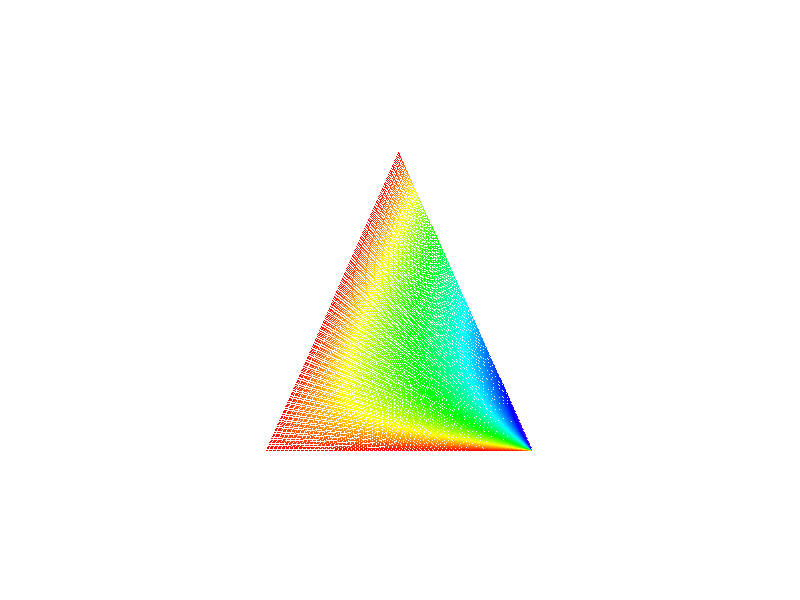

This is the graph for the basic Price of Anarchy problem with 2 computers and 2 routers and individual $\beta$ values for each router. The leftmost corner represents total zero efficiency on both routers, and the rightmost represents perfect efficiency. The left edge of the triangle, going upwards, represents increasing values of $\beta_1$. Each line connecting this edge to the rightmost corner represents a sequence of values of increasing $\beta_2$, giving us our graph. For higher dimensions, the additional point we add for our hyperpyramid is connected to each of the points on each of the lines of the $n-1$-dimensional hyperpyramid to represent the additional $\beta$. For more information, see the original write-up on the rendering system.

In this model, we use the HSL colorspace to represent the expected number of packets. H = 0 represents zero packets, up to H = 360 representing the full capacity of the system. Areas of the same color are areas of indifference; that is, these are combinations of $\beta$ where the expected number of packets is the same. We see in this particular situation that these are roughly curved around places where only one $\beta$ value changes; where both $\beta$ values change, the expected number of packets increases.

Note for some higher dimensional objects, the colorspace may be slightly offset due to an initial discrepancy in accounting for the color scaling for these extra routers. Proportionally, the shapes of the indifference curves should remain the same.

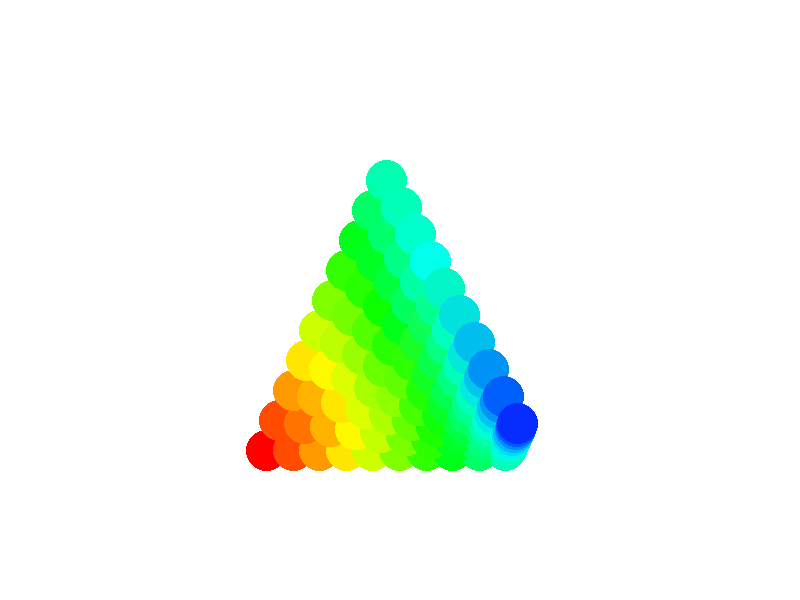

This is the socially optimal result of the above setup, although the bottom right corner is missing a singular disc.

Unlike with the Nash equilibrium, the curves of indifference propagate with a higher degree of linearity when moving from the left corner. This is because in the socially optimal setup, a change of any of the $\beta$ values will result in efficiency improvements, rather than just a change in all of them as before.

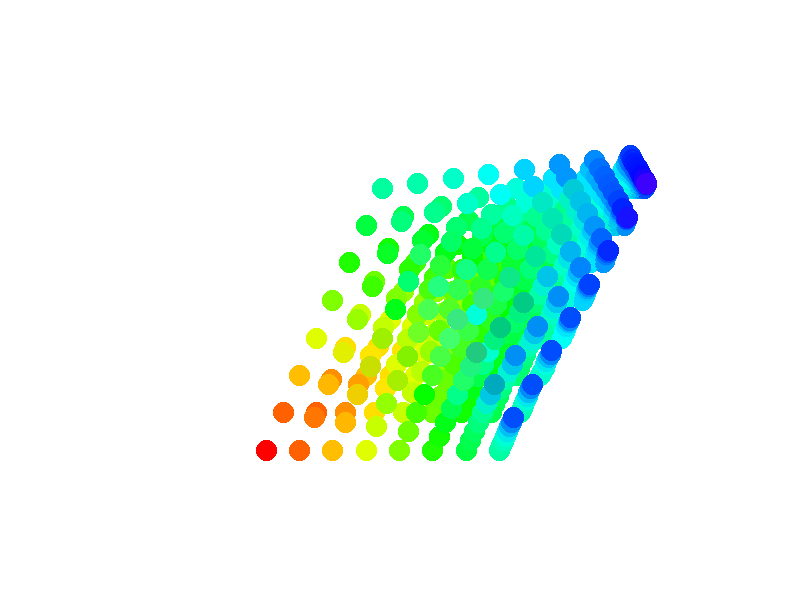

This is the graph for 2 computers and 3 routers in the socially optimal setup. If you look closely, it resembles a triangular pyramid formed by a sequence of triangles starting from a face at the front and propagating backwards and to the right. Similarly to before, we see efficiency improvements on all $\beta$ axes, and two definite positions representing total inefficiency and perfect efficiency.

Compared to the previous setup, $\beta_2$ is represented as a series of lines going from each of the points on the front face of the pyramid, which is similar to the original triangle in the previous setup, linked to a single point at the rightmost area of the pyramid. The frontmost portions of these lines represent $\beta_2 = 0$, and the rearmost represent $\beta_2 = 1$. Again, see the original writeup of the rendering system for more information on how these probability sequences are represented.

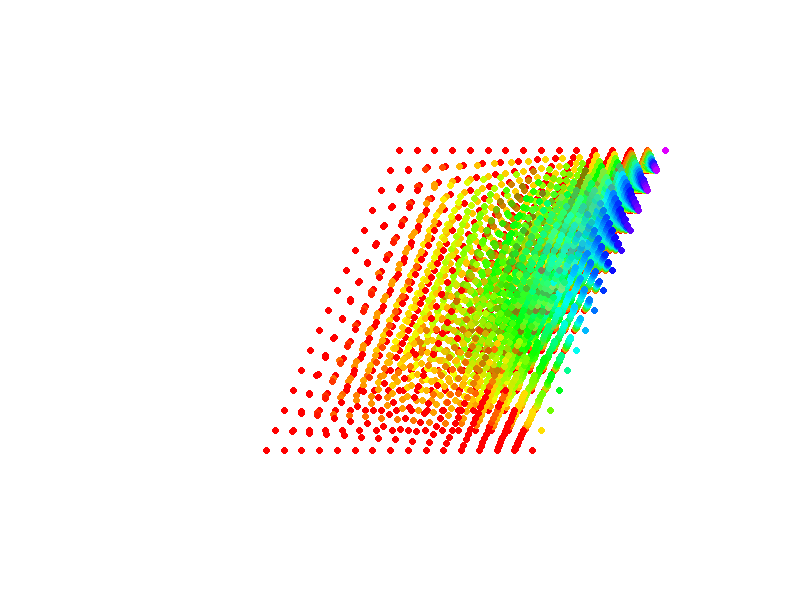

This is the Nash equilibrium graph for 2 computers and 3 routers. We can clearly see the subtriangles that form the greater triangular pyramid are very similar to that of the 2 computer 2 router setup, with distinctive right-angle curving indifference curves.

These curves also show up when looking at the pyramid from the right hand side face-on, where the direction of increasing network efficiency is the general direction of increasing $\beta$ values for all $\beta$ values in play.

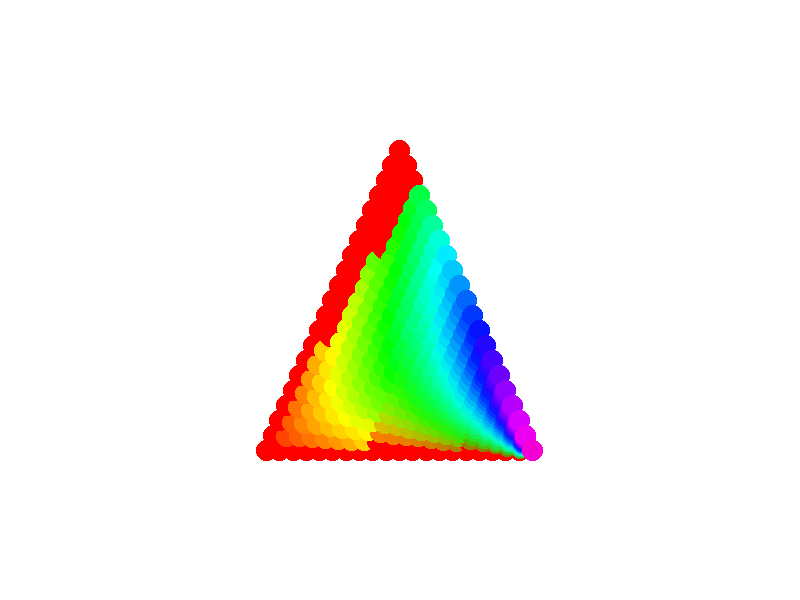

This is the graph for 3 computers and 2 routers. Note it is very similar to the setup for 2 computers and 3 routers, but with higher expected payoffs. Also note the presence of pink on the right hand side; this is because HSL is a radial color system, and that H = 0 is the same as H = 360, or red.

Also note the large swath of red bordering the green on the left hand side. This is because in higher dimensions, the Newton's method approximation fails to converge and so these values have to be set to zero, or red, creating this red region.

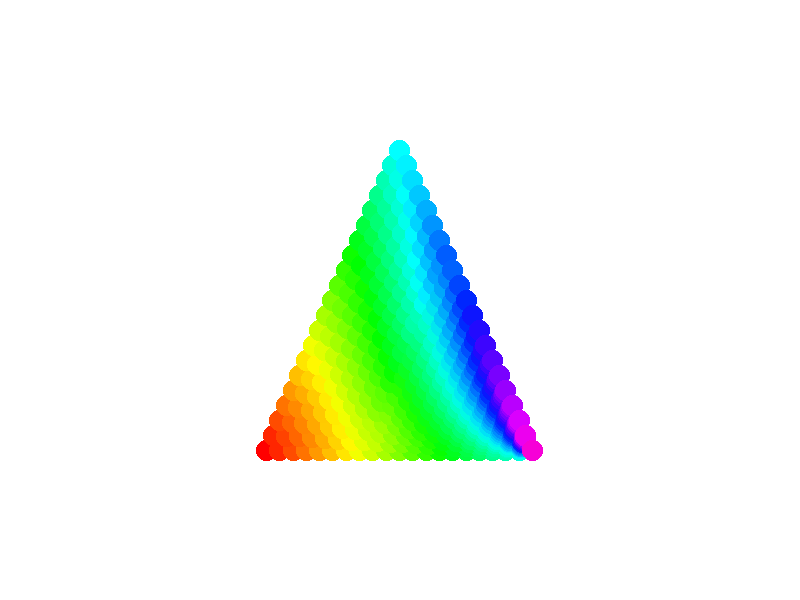

This is the socially optimal graph for 3 computers and 2 routers. It is also very similar to the 2 computer 2 router setup, but since there are no convergence issues, we see the full extent of the graph. We again see overall higher expected payoffs.

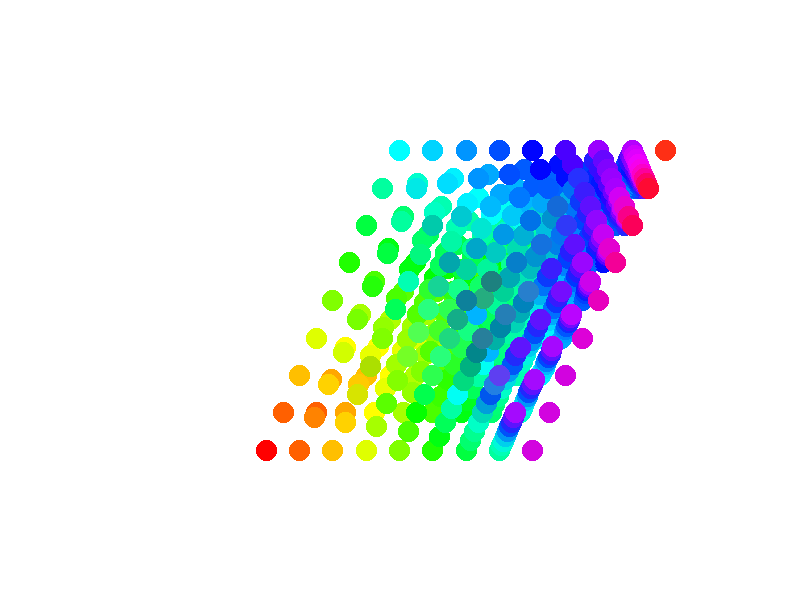

This is the graph for the socially optimal result for 3 computers and 3 routers. The same results as the setup with 2 computers is seen once again, albeit with, once again, higher total expected payoffs, as denoted by the shift in the colorspace. Unfortunately, the graph for the Nash equilibrium version of this problem takes far too long to render, and so it is not presented here.

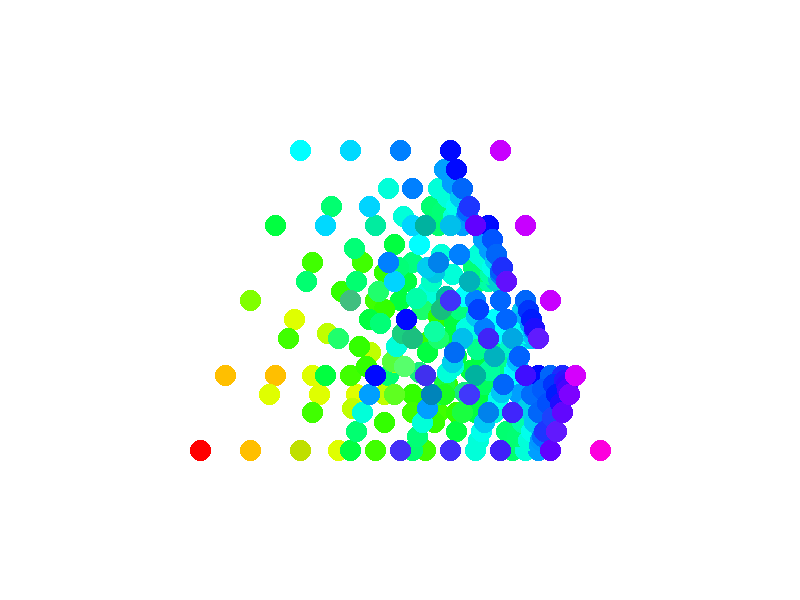

Finally, this is the graph for 2 computers and 4 routers in the socially optimal scenario. While it may look like a sequence of dots, these dots form the wireframe of a 4-dimensional hyperpyramid created by repeated slices of triangular pyramids. Again, there are distinctive corners for the maximally inefficient and efficient outcomes, and we see general directions of efficiency improvement where any value of $\beta$ is increased, which is in all four dimensions of this object.

In conclusion, we see that the results we found in each independent extension of the Price of Anarchy model continue to apply in the merged model. When we add more routers to the system, we have a greater range of areas by which higher efficiency is achieved in the socially optimal scenario, which represents the greater capacity of the system. In the Nash equilibrium, we see a proportionate expansion of each efficiency level, which represents that ultimately computers will continue to behave the same towards the same types of routers.

When we add more computers, the overall expected packets processed increases. This once again is due to the higher number of computers increasing the probability of any one router actually being used, which increases the probability of total system usage, both in the socially optimal and Nash equilibrium results.

## Conclusion and Avenues of Expansion

In closing, the Price of Anarchy problem gives numerous results when scaled to a network of arbitrary size. We see unregulated and regulated network utilization improvements from adding extra computers, along with various effects from adding more routers depending on the type of routers added. We see that unlike the basic problem where the Price of Anarchy was bounded to a relatively small degree, modifying the system may both increase or decrease the improvements by which network regulation is capable of achieving. Thus, it is crucial to consider every aspect of a particular system when deciding on how a network should be managed, as a network is only as good as its weakest link.

On top of the extensions explored here, there are other avenues by which generalizations could be explored in the future. It is possible to modify the problem to allow each computer to be restricted to only a subset of the total number of routers available in the network, modeling network locales and enterprise-restricted router deployments. This would require having additional $\pi$ values for each router and would mean the game were no longer symmetric, complicating some of the prior calculations.

Another avenue of expansion would be to consider packet retry. This is a method where if a packet is failed to be sent, it is sent again and again until it is finally processed. This would require the introduction of a time series variable into the problem, the scale of which is out of the scope of this notebook and is left as an exercise to the reader.

## Works Cited

Peters, Michael. (2016) *The Price of Anarchy* \[PDF\]. Retrieved from https://montoya.econ.ubc.ca/Econ306/price_of_anarchy.pdf

Yu, James. (2020) *Expected Utility Visualizer*. Retrieved from https://repl.it/@JPhoton/ExpectedUtilityVisualizer

Yu, James. (2021) *QuantEcon*. Retrieved from https://github.com/jbrightuniverse/QuantEcon

## Works Consulted

(2016) *Systems of Nonlinear Equations* \[PowerPoint Slides\]. Retrieved from http://homepage.math.uiowa.edu/~whan/3800.d/S7-3.pdf

Peters, Michael. (2021) *306_anarchy.ipynb* \[Jupyter Notebook\]. Retrieved from https://github.com/michaelpetersubc/notebooks/blob/master/Econ306/price_of_anarchy/306_anarchy.ipynb